# Analiza średnich temperatur dziennych w Warszawie i Lizbonie

## Linki
- overleaf - https://www.overleaf.com/project/66298573c5690e43b5b33c70

## Biblioteki

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

colors = ['#cd203b', '#006300']

## Przygotowanie danych

Odczyt danych w których pozostawiliśmy tylko Warszawę i Lisbonę (edycja w Excel)

In [3]:
data_path_warsaw_lisbon = 'warsawlisbon.csv'
warsaw_lisbon_data = pd.read_csv(data_path_warsaw_lisbon)

warsaw_lisbon_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Poland,NaN,Warsaw,1,1,1995,35.4
1,Europe,Poland,NaN,Warsaw,1,2,1995,30.5
2,Europe,Poland,NaN,Warsaw,1,3,1995,27.2
3,Europe,Poland,NaN,Warsaw,1,4,1995,22.9
4,Europe,Poland,NaN,Warsaw,1,5,1995,18.7


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [4]:
warsaw_lisbon_data = warsaw_lisbon_data.drop('Region', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('Country', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('State', axis=1)

warsaw_lisbon_data

,City,Month,Day,Year,AvgTemperature
0,Warsaw,1,1,1995,35.4
1,Warsaw,1,2,1995,30.5
2,Warsaw,1,3,1995,27.2
3,Warsaw,1,4,1995,22.9
4,Warsaw,1,5,1995,18.7
...,...,...,...,...,...
18527,Lisbon,5,9,2020,59.8
18528,Lisbon,5,10,2020,60.0
18529,Lisbon,5,11,2020,60.3
18530,Lisbon,5,12,2020,59.6


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [5]:
warsaw_lisbon_data["Month"] = pd.to_numeric(warsaw_lisbon_data["Month"])
warsaw_lisbon_data["Day"] = pd.to_numeric(warsaw_lisbon_data["Day"])
warsaw_lisbon_data["Year"] = pd.to_numeric(warsaw_lisbon_data["Year"])
warsaw_lisbon_data["AvgTemperature"] = pd.to_numeric(warsaw_lisbon_data["AvgTemperature"])

Dzielimy dane na miasta i sortujemy datą

In [6]:
warsaw_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Warsaw']
lisbon_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Lisbon']

warsaw_data['Date'] = pd.to_datetime(warsaw_data[['Year', 'Month', 'Day']])
lisbon_data['Date'] = pd.to_datetime(lisbon_data[['Year', 'Month', 'Day']])

warsaw_data = warsaw_data.sort_values(by='Date')
lisbon_data = lisbon_data.sort_values(by='Date')

### Błędna numeracja wierszy

Natomiast po takim podziale, zauważmy że występuje problem z numeracją wierszy

In [7]:
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
9266,Lisbon,1,1,1995,53.5,1995-01-01
9267,Lisbon,1,2,1995,46.9,1995-01-02
9268,Lisbon,1,3,1995,45.8,1995-01-03
9269,Lisbon,1,4,1995,53.3,1995-01-04
9270,Lisbon,1,5,1995,56.2,1995-01-05


Poprawmy go

In [8]:
lisbon_data.reset_index(drop=True, inplace=True)
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
0,Lisbon,1,1,1995,53.5,1995-01-01
1,Lisbon,1,2,1995,46.9,1995-01-02
2,Lisbon,1,3,1995,45.8,1995-01-03
3,Lisbon,1,4,1995,53.3,1995-01-04
4,Lisbon,1,5,1995,56.2,1995-01-05


Zobaczmy jak dane się prezentują na wykresie

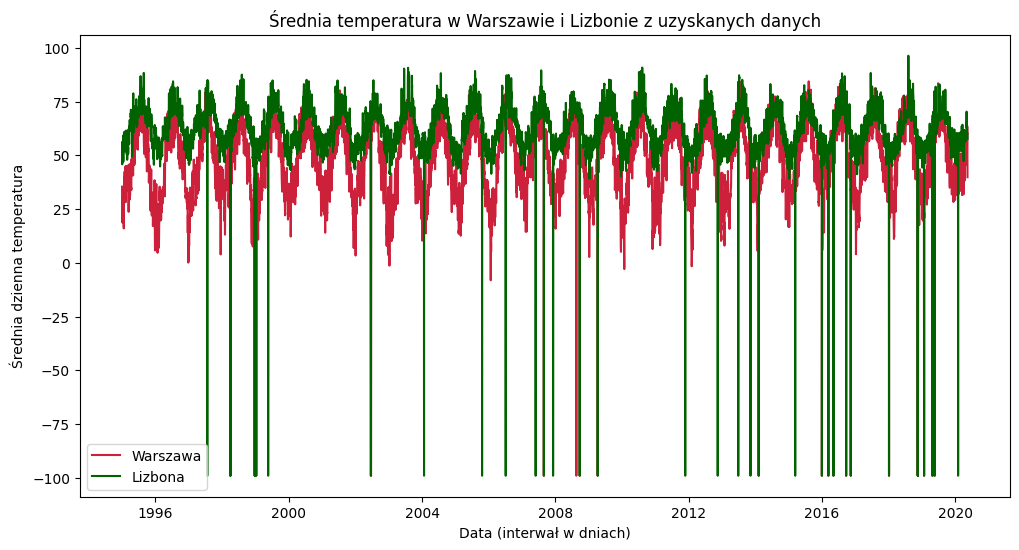

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie z uzyskanych danych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.legend()
plt.show()

### Brakujące wartości

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [10]:
lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
934,Lisbon,7,23,1997,-99.0,1997-07-23
1184,Lisbon,3,30,1998,-99.0,1998-03-30
1189,Lisbon,4,4,1998,-99.0,1998-04-04
1190,Lisbon,4,5,1998,-99.0,1998-04-05
1453,Lisbon,12,24,1998,-99.0,1998-12-24


Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [11]:
lisbon_data['AvgTemperature_New'] = lisbon_data['AvgTemperature']

for i in range(len(lisbon_data)):
    if lisbon_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = lisbon_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        lisbon_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature_New']
lisbon_data = lisbon_data.drop('AvgTemperature_New', axis=1)

lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. To samo robimy dla Warszawy.

In [12]:
warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
1453,Warsaw,12,24,1998,-99.0,1998-12-24
1454,Warsaw,12,25,1998,-99.0,1998-12-25
1459,Warsaw,12,30,1998,-99.0,1998-12-30
1460,Warsaw,12,31,1998,-99.0,1998-12-31
1470,Warsaw,1,10,1999,-99.0,1999-01-10


In [13]:
warsaw_data['AvgTemperature_New'] = warsaw_data['AvgTemperature']

for i in range(len(warsaw_data)):
    if warsaw_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = warsaw_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        warsaw_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature_New']
warsaw_data = warsaw_data.drop('AvgTemperature_New', axis=1)

warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Zobaczmy wykres po tych modyfikacjach

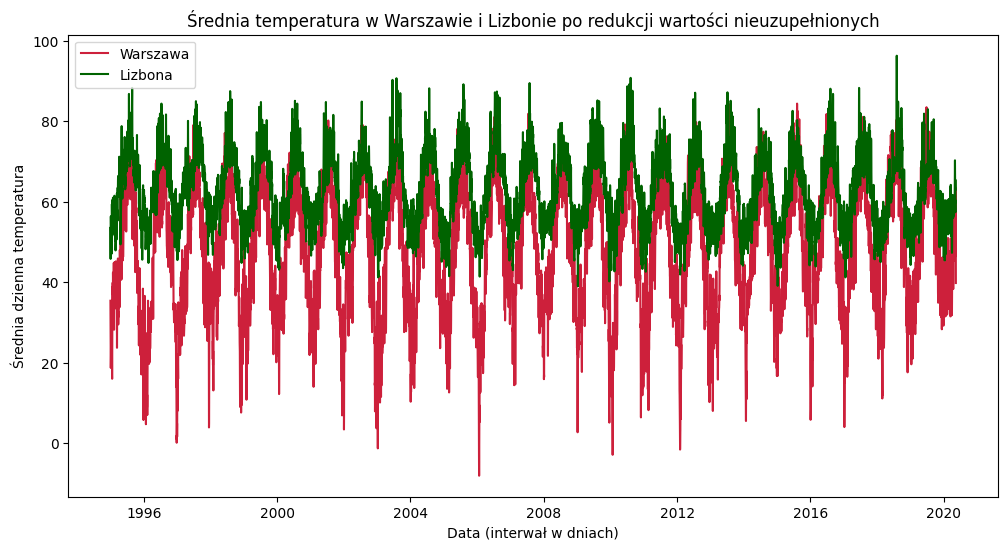

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie po redukcji wartości nieuzupełnionych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.legend()
plt.show()

### Konwersja stopni

Wartośc są mniej niepokojące jednak 100 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [15]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature'].apply(fahrenheit_to_celsius)
lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

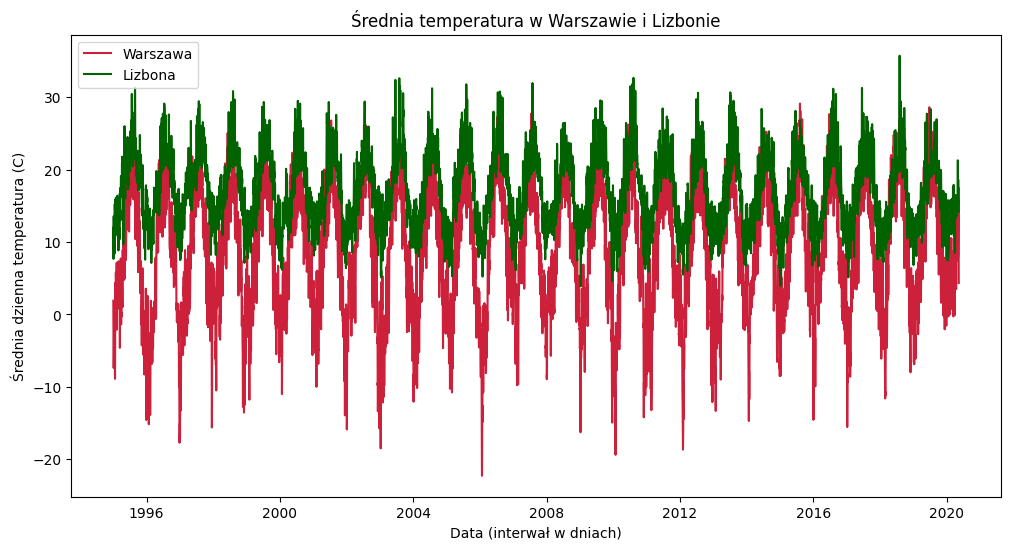

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warszawa', color=colors[0])
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lizbona', color=colors[1])

plt.title('Średnia temperatura w Warszawie i Lizbonie')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura (C)')

plt.legend()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

Rozpocznijmy od zastosowania podstawowych pojęć statystycznych do tych danych

- Warszawa

In [17]:
warsaw_data['AvgTemperature'].describe()

count    9266.000000
mean        9.026345
std         8.719466
min       -22.277778
25%         2.277778
50%         9.222222
75%        16.222222
max        29.111111
Name: AvgTemperature, dtype: float64

- Lizbona

In [18]:
lisbon_data['AvgTemperature'].describe()

count    9266.000000
mean       17.011166
std         4.883680
min         3.888889
25%        13.111111
50%        16.777778
75%        20.722222
max        35.722222
Name: AvgTemperature, dtype: float64

## Analiza danych

### Boxplot

Zacznijmy od poznania danych boxplotem

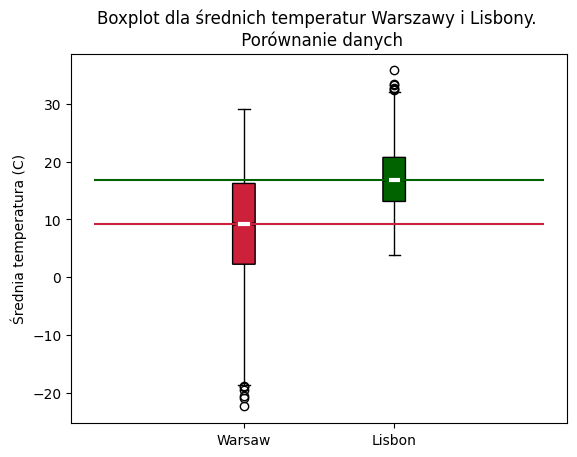

In [19]:
bp = plt.boxplot([warsaw_data.AvgTemperature, lisbon_data.AvgTemperature], patch_artist = True, notch ='True')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# medians
for median in bp['medians']:
    median.set(color ='white',
               linewidth = 3)
            
plt.hlines(warsaw_data.AvgTemperature.median(), 0, 3, color=colors[0])
plt.hlines(lisbon_data.AvgTemperature.median(), 0, 3, color=colors[1])

plt.xticks([1, 2], ['Warsaw', 'Lisbon'])

plt.title('Boxplot dla średnich temperatur Warszawy i Lisbony. \n Porównanie danych')
plt.ylabel('Średnia temperatura (C)')

plt.show()

Tutaj zauważamy już dość sporo informacji o naszych danych:
- Średnia temperatury w Lizbonie jest znacząco wyższa niż w Warszawie. To sugeruje, że Lizbona ma cieplejszy klimat niż Warszawa.
- Zmienność temperatury w Warszawie jest znacznie większa niż w Lizbonie: Odchylenie standardowe dla Warszawy wynosi 8.72°C, podczas gdy dla Lizbony jest to 4.88°C.
- Średnia temperatura Lizbony przekracza trzeci kwartyl Warszawy. To sugeruje, że temperatura w Lizbonie jest ogólnie wyższa niż w Warszawie.

### Gęstość

Następnie spójrzmy na te dane jeszcze na histogramie

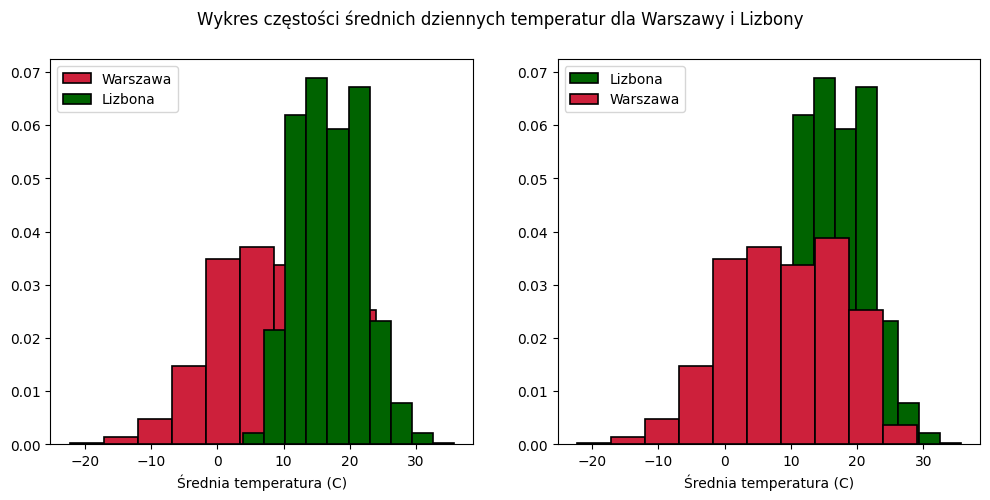

In [20]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5),)

axis[0].hist(warsaw_data.AvgTemperature, density=True, color=colors[0], label='Warszawa', edgecolor='black', linewidth=1.2)
axis[0].hist(lisbon_data.AvgTemperature, density=True, color=colors[1], label='Lizbona', edgecolor='black', linewidth=1.2)

axis[1].hist(lisbon_data.AvgTemperature, density=True, color=colors[1], label='Lizbona', edgecolor='black', linewidth=1.2)
axis[1].hist(warsaw_data.AvgTemperature, density=True, color=colors[0], label='Warszawa', edgecolor='black', linewidth=1.2)

axis[0].legend()
axis[1].legend()

axis[0].set_xlabel('Średnia temperatura (C)')
axis[1].set_xlabel('Średnia temperatura (C)')

figure.suptitle('Wykres częstości średnich dziennych temperatur dla Warszawy i Lizbony')
plt.show()

Porównajmy z odpowiednimi gęstościami teoretycznymi rozkładu normalnego.

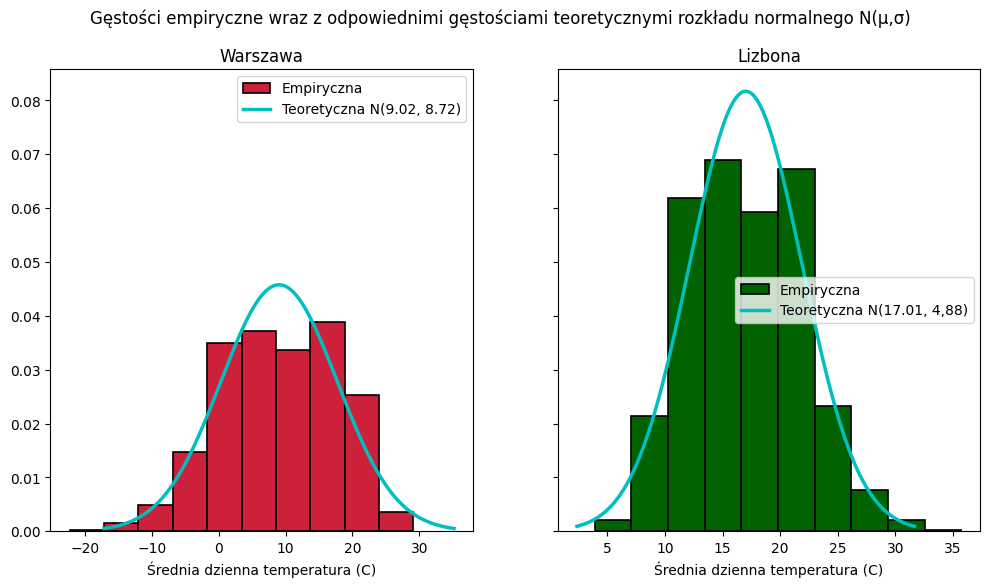

In [54]:
Mean_Warsaw = np.mean(warsaw_data.AvgTemperature)
Mean_Lisbon = np.mean(lisbon_data.AvgTemperature)

Std_Warsaw = np.std(warsaw_data.AvgTemperature)
Std_Lisbon = np.std(lisbon_data.AvgTemperature)

x_warsaw = np.linspace(Mean_Warsaw - 3*Std_Warsaw, Mean_Warsaw + 3*Std_Warsaw, 1000)
x_lisbon = np.linspace(Mean_Lisbon - 3*Std_Lisbon, Mean_Lisbon + 3*Std_Lisbon, 1000)

Normal_Density_Warsaw = scipy.stats.norm.pdf(x_warsaw, Mean_Warsaw, Std_Warsaw)
Normal_Density_Lisbon = scipy.stats.norm.pdf(x_lisbon, Mean_Lisbon, Std_Lisbon)

figure, axis = plt.subplots(1, 2, figsize=(12, 6), sharex='col', sharey='row')
axis[0].hist(warsaw_data.AvgTemperature, density=True, color=colors[0], label='Empiryczna', edgecolor='black', linewidth=1.2)
axis[0].plot(x_warsaw, Normal_Density_Warsaw, label='Teoretyczna N(9.02, 8.72)', color='c', linewidth=2.5)
axis[0].set_xlabel('Średnia dzienna temperatura (C)')
axis[0].legend()
axis[0].set_title('Warszawa')

axis[1].hist(lisbon_data.AvgTemperature, density=True, color=colors[1], label='Empiryczna', edgecolor='black', linewidth=1.2)
axis[1].plot(x_lisbon, Normal_Density_Lisbon, label='Teoretyczna N(17.01, 4,88)', color='c', linewidth=2.5)
axis[1].set_xlabel('Średnia dzienna temperatura (C)')
axis[1].legend(loc='upper right')
axis[1].set_title('Lizbona')

plt.suptitle("Gęstości empiryczne wraz z odpowiednimi gęstościami teoretycznymi rozkładu normalnego N(μ,σ)")
plt.show()


### Dystrybuanta

Po otrzymaniu histogramu, czyli "empirycznej gęstości" spójrzmy na dystrybuantę

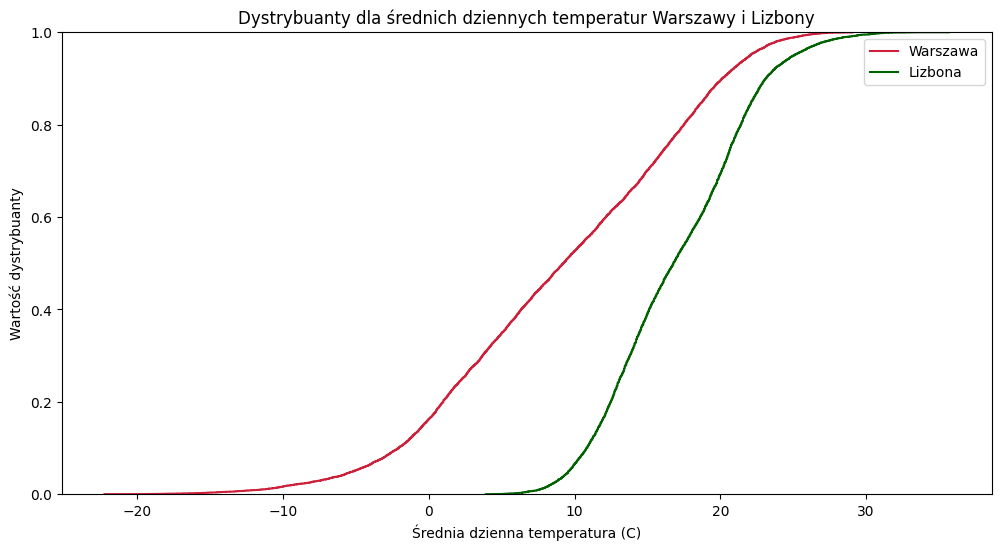

In [22]:
plt.figure(figsize=(12, 6))

sns.ecdfplot(data=warsaw_data.AvgTemperature, label="Warszawa", c=colors[0])
sns.ecdfplot(data=lisbon_data.AvgTemperature, label="Lizbona", c=colors[1])

plt.title('Dystrybuanty dla średnich dziennych temperatur Warszawy i Lizbony')
plt.xlabel('Średnia dzienna temperatura (C)')
plt.ylabel('Wartość dystrybuanty')

plt.legend()
plt.show()

Dopasujmy do odpowiednich dystrybuant teoretycznych rozkładu normalnego.

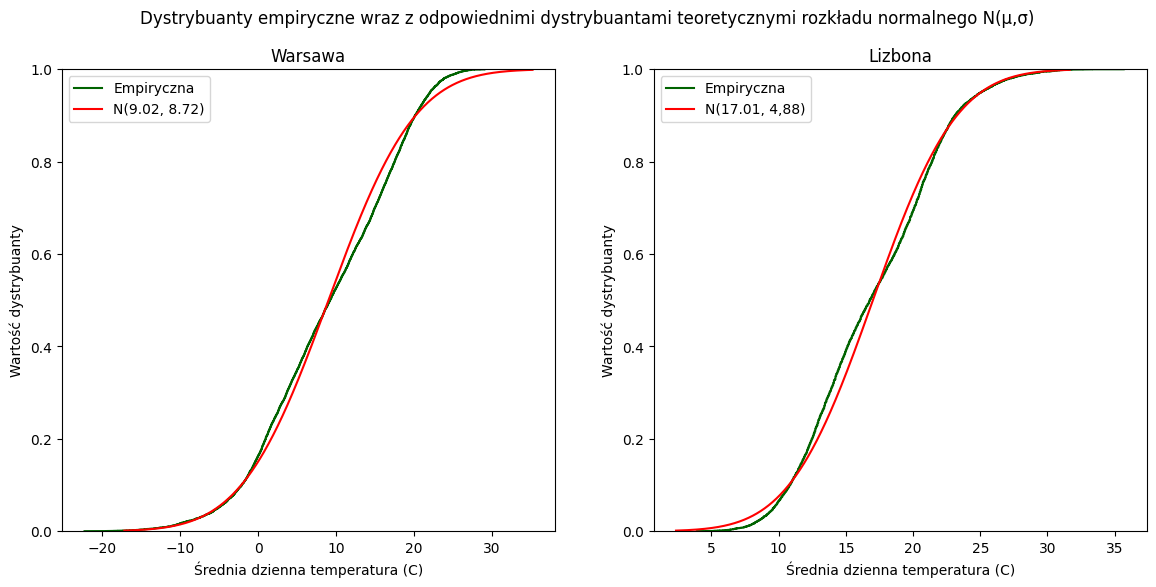

In [23]:
Normal_CDF_Warsaw = scipy.stats.norm.cdf(x_warsaw, Mean_Warsaw, Std_Warsaw)
Normal_CDF_Lisbon = scipy.stats.norm.cdf(x_lisbon, Mean_Lisbon, Std_Lisbon)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.ecdfplot(data=warsaw_data.AvgTemperature, label="Empiryczna", c=colors[1])
plt.plot(x_warsaw, Normal_CDF_Warsaw, label='N(9.02, 8.72)', color='r', linewidth=1.5)
plt.xlabel('Średnia dzienna temperatura (C)')
plt.ylabel('Wartość dystrybuanty')
plt.legend()
plt.title('Warsawa')

plt.subplot(1, 2, 2)
sns.ecdfplot(data=lisbon_data.AvgTemperature, label="Empiryczna", c=colors[1])
plt.plot(x_lisbon, Normal_CDF_Lisbon, label='N(17.01, 4,88)', color='r', linewidth=1.5)
plt.xlabel('Średnia dzienna temperatura (C)')
plt.ylabel('Wartość dystrybuanty')
plt.legend()
plt.title('Lizbona')

plt.suptitle("Dystrybuanty empiryczne wraz z odpowiednimi dystrybuantami teoretycznymi rozkładu normalnego N(μ,σ)")
plt.show()

### Średnie

Podczas zajęć poznaliśmy sporo różnych metod obliczania średnich, użyjmy ich do naszych danych

#### Średnia arytmetyczna

In [24]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Średnia arytmetyczna z danych": [
        np.mean(warsaw_data.AvgTemperature),
        np.mean(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Średnia arytmetyczna z danych
0,Warszawa,9.026345
1,Lizbona,17.011166


#### Średnia geometryczna

Może być tylko dla dodatnich danych -> odpada

#### Średnia harmoniczna

Może być tylko dla dodatnich danych -> odpada

#### Średnia ucinana

<i>Kod wzorowany na zad 3 z listy 2</i>

##### Metoda

In [25]:
def cut_mean(x, k):
    s = np.sum(x[k : len(x) - k])
    return (1 / (len(x) - 2*k)) * s


##### Prezentacja

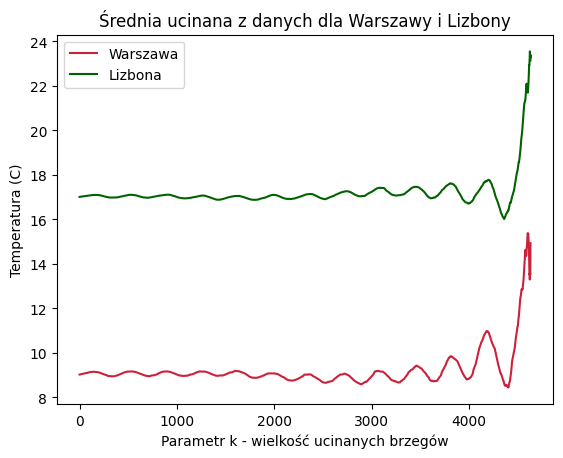

In [26]:
n = round((len(warsaw_data) / 2)) - 1
x_k = np.zeros(n)
y_warsaw_cut_mean = np.zeros(n)
y_lisbon_cut_mean = np.zeros(n)

for k_i in range(n):
    x_k[k_i] = k_i
    y_warsaw_cut_mean[k_i] = cut_mean(warsaw_data.AvgTemperature, k_i)
    y_lisbon_cut_mean[k_i] = cut_mean(lisbon_data.AvgTemperature, k_i)

plt.plot(x_k, y_warsaw_cut_mean, label='Warszawa', color=colors[0])
plt.plot(x_k, y_lisbon_cut_mean, label="Lizbona", color=colors[1])

plt.title('Średnia ucinana z danych dla Warszawy i Lizbony')
plt.xlabel('Parametr k - wielkość ucinanych brzegów')
plt.ylabel('Temperatura (C)')

plt.legend()
plt.show()

#### Średnia winsorowska

<i>Kod wzorowany na zad 3 z listy 2</i>

##### Metoda

In [27]:
def wins_mean(x, k):
    s = np.sum(x[k + 1 : len(x) - k - 1])
    return (1 / len(x)) * ((k+1) * x[k] + s + (k+1) * x[len(x) - k - 1])

##### Prezentacja

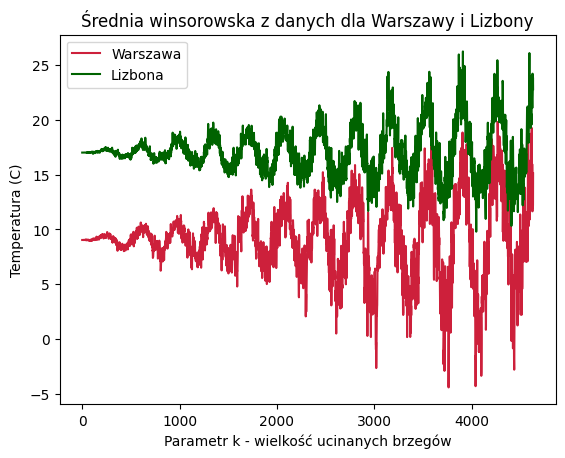

In [28]:
n = round((len(warsaw_data) / 2)) - 1
x_k = np.zeros(n)
y_warsaw_wins_mean = np.zeros(n)
y_lisbon_wins_mean = np.zeros(n)

for k_i in range(n):
    x_k[k_i] = k_i
    y_warsaw_wins_mean[k_i] = wins_mean(warsaw_data.AvgTemperature, k_i)
    y_lisbon_wins_mean[k_i] = wins_mean(lisbon_data.AvgTemperature, k_i)

plt.plot(x_k, y_warsaw_wins_mean, label='Warszawa', color=colors[0])
plt.plot(x_k, y_lisbon_wins_mean, label="Lizbona", color=colors[1])

plt.title('Średnia winsorowska z danych dla Warszawy i Lizbony')
plt.xlabel('Parametr k - wielkość ucinanych brzegów')
plt.ylabel('Temperatura (C)')

plt.legend()
plt.show()

#### Średnia winsorowska vs ucinana

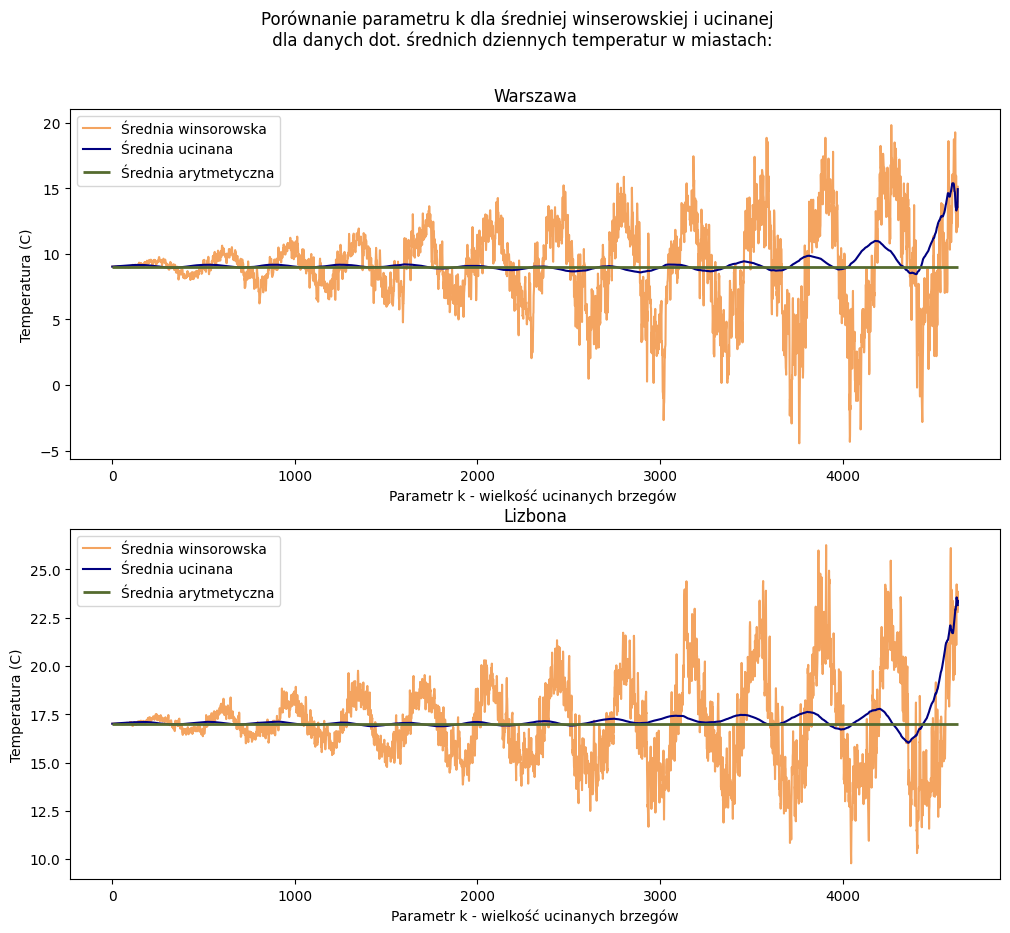

In [29]:
figure, axis = plt.subplots(2, 1, figsize=(12, 10))

axis[0].plot(x_k, y_warsaw_wins_mean, label="Średnia winsorowska", color='sandybrown')
axis[0].plot(x_k, y_warsaw_cut_mean, label='Średnia ucinana', color='navy')
axis[0].hlines(np.mean(warsaw_data.AvgTemperature), x_k[0], x_k[-1], label='Średnia arytmetyczna', color='darkolivegreen', linewidth=2)

axis[1].plot(x_k, y_lisbon_wins_mean, label="Średnia winsorowska", color='sandybrown')
axis[1].plot(x_k, y_lisbon_cut_mean, label='Średnia ucinana', color='navy')
axis[1].hlines(np.mean(lisbon_data.AvgTemperature), x_k[0], x_k[-1], label='Średnia arytmetyczna', color='darkolivegreen', linewidth=2)

axis[0].set_title('Warszawa')
axis[0].set_xlabel('Parametr k - wielkość ucinanych brzegów \n')
axis[0].set_ylabel('Temperatura (C)')

axis[1].set_title('Lizbona')
axis[1].set_xlabel('Parametr k - wielkość ucinanych brzegów')
axis[1].set_ylabel('Temperatura (C)')

plt.suptitle('Porównanie parametru k dla średniej winserowskiej i ucinanej \n dla danych dot. średnich dziennych temperatur w miastach:')

axis[0].legend()
axis[1].legend()
plt.show()

Ciekawa obserwacja -> jak obcinamy pory roku średnia winduje w góre lub w dół -> jeśli obcinamy cały rok wraca do normy :)

##### Mediana

a) funkcja wbudowana

In [30]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Mediana z danych": [
        np.median(warsaw_data.AvgTemperature),
        np.median(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Mediana z danych
0,Warszawa,9.222222
1,Lizbona,16.777778


b) customowo z zajęć

In [31]:
def mediana(dane):
    dane = sorted(dane)
    n = len(dane)
    if n%2 == 1:
        return dane[n // 2]
    else:
        x1 = dane[n//2 - 1]
        x2 = dane[n//2]
        return (x1 + x2) / 2
    

In [32]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Mediana z danych": [
        mediana(warsaw_data.AvgTemperature),
        mediana(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Mediana z danych
0,Warszawa,9.222222
1,Lizbona,16.777778


#### Kwartyle i rozstęp międzykwartylowy

a) funkcje wbudowane

In [33]:
Q1_Warsaw = np.quantile(warsaw_data.AvgTemperature, 0.25, method = 'midpoint')
Q1_Lisbon = np.quantile(lisbon_data.AvgTemperature, 0.25, method = 'midpoint')

Q3_Warsaw = np.quantile(warsaw_data.AvgTemperature, 0.75, method = 'midpoint')
Q3_Lisbon = np.quantile(lisbon_data.AvgTemperature, 0.75, method = 'midpoint')

df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Q1": [
        Q1_Warsaw,
        Q1_Lisbon,
    ],
    "Q2": [
        mediana(warsaw_data.AvgTemperature),
        mediana(lisbon_data.AvgTemperature),
    ],
    "Q3": [
        Q3_Warsaw,
        Q3_Lisbon,
    ],
    "IQR": [
        (Q3_Warsaw - Q1_Warsaw),
        (Q3_Lisbon - Q1_Lisbon),
    ],
})

df

,Miasto,Q1,Q2,Q3,IQR
0,Warszawa,2.277778,9.222222,16.222222,13.944444
1,Lizbona,13.111111,16.777778,20.722222,7.611111


b) customowe funkcje z zajęc

In [34]:
def kwartyle(dane):
    dane = sorted(dane)
    n = len(dane)
    q2 = mediana(dane)
    
    if n%2 == 1:
        q1 = mediana(dane[:n // 2])
        q3 = mediana(dane[n // 2 + 1:])
    else:
        q1 = mediana(dane[:n // 2])
        q3 = mediana(dane[n//2:])
    
    return q1, q2, q3

In [35]:
Quartils_Warsaw = kwartyle(warsaw_data.AvgTemperature)
Quartils_Lisbon = kwartyle(lisbon_data.AvgTemperature)

df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Q1": [
        Quartils_Warsaw[0],
        Quartils_Lisbon[0],
    ],
    "Q2": [
        Quartils_Warsaw[1],
        Quartils_Lisbon[1],
    ],
    "Q3": [
        Quartils_Warsaw[2],
        Quartils_Lisbon[2],
    ],
    "IQR": [
        (Quartils_Warsaw[2] - Quartils_Warsaw[0]),
        (Quartils_Lisbon[2] - Quartils_Lisbon[0]),
    ],
})

df

,Miasto,Q1,Q2,Q3,IQR
0,Warszawa,2.277778,9.222222,16.222222,13.944444
1,Lizbona,13.111111,16.777778,20.722222,7.611111


### Inne wyznaczniki matematyczne

#### Korelacja

In [36]:
def pearson_correlation(X,Y):
    """
    https://www.geeksforgeeks.org/exploring-correlation-in-python/
    """
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

corr = pearson_correlation(warsaw_data.AvgTemperature, lisbon_data.AvgTemperature)

f"Korelacja między danymi Warszawy i Lizbony: {corr}"

'Korelacja między danymi Warszawy i Lizbony: 0.7192633730393783'

#### Wariancja

In [37]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Wariancja z danych": [
        np.var(warsaw_data.AvgTemperature, ddof=1),
        np.var(lisbon_data.AvgTemperature, ddof=1),
    ]
})

df

,Miasto,Wariancja z danych
0,Warszawa,76.029081
1,Lizbona,23.850331


#### Odchylenie standardowe

In [38]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Odchylenie standardowe z danych": [
        np.sqrt(np.var(warsaw_data.AvgTemperature, ddof=1)),
        np.sqrt(np.var(lisbon_data.AvgTemperature, ddof=1)),
    ]
})

df

,Miasto,Odchylenie standardowe z danych
0,Warszawa,8.719466
1,Lizbona,4.883680


In [39]:
V_Warsaw = ((np.sqrt(np.var(warsaw_data.AvgTemperature, ddof=1))) / (np.mean(warsaw_data.AvgTemperature))) * 100
V_Lisbon = ((np.sqrt(np.var(lisbon_data.AvgTemperature, ddof=1))) / (np.mean(lisbon_data.AvgTemperature))) * 100

df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Współczynnik zmienności [%]": [
        f'{V_Warsaw} %',
        f'{V_Lisbon} %',
    ]
})

df

,Miasto,Współczynnik zmienności [%]
0,Warszawa,96.60018309267974 %
1,Lizbona,28.70867257286053 %


#### Skośność

In [40]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Skośność danych": [
        scipy.stats.skew(warsaw_data.AvgTemperature),
        scipy.stats.skew(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Skośność danych
0,Warszawa,-0.229187
1,Lizbona,0.204054


#### Kurtoza

a) wbudowane scipy

In [41]:
df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Kurtoza danych": [
        scipy.stats.kurtosis(warsaw_data.AvgTemperature, fisher=False, bias=False),
        scipy.stats.kurtosis(lisbon_data.AvgTemperature, fisher=False, bias=False),
    ]
})

df

,Miasto,Kurtoza danych
0,Warszawa,2.412212
1,Lizbona,2.490245


b) z wykładu

In [42]:
def K1(dane):
    n = len(dane)
    mean_dane = np.mean(dane)
    sum1 = np.sum((dane - mean_dane)**4)
    sum2 = np.sum((dane - mean_dane)**2)
    
    licznik = sum1 / n
    mianownik = (sum2 / n)**2

    return licznik / mianownik

def kurtoza(dane):
    n = len(dane)
    myK1 = K1(dane)
    return ((n-1)/((n-2)*(n-3))) * ((n+1) * myK1 - 3*(n-1)) + 3


df = pd.DataFrame({
    "Miasto": ['Warszawa', 'Lizbona'],
    "Kurtoza danych": [
        kurtoza(warsaw_data.AvgTemperature),
        kurtoza(lisbon_data.AvgTemperature),
    ]
})

df

,Miasto,Kurtoza danych
0,Warszawa,2.412212
1,Lizbona,2.490245
